# Climate Change Prediction Using Time Series Analysis

In [64]:
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from datetime import datetime, timedelta
from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

In [18]:
df = pd.read_csv("./data/globaltempByState.csv")

In [19]:
df.head(10)

,dt,AverageTemperature,AverageTemperatureUncertainty,State,Country
0,1855-05-01,25.544,1.171,Acre,Brazil
1,1855-06-01,24.228,1.103,Acre,Brazil
2,1855-07-01,24.371,1.044,Acre,Brazil
3,1855-08-01,25.427,1.073,Acre,Brazil
4,1855-09-01,25.675,1.014,Acre,Brazil
5,1855-10-01,25.442,1.179,Acre,Brazil
6,1855-11-01,25.400,1.064,Acre,Brazil
7,1855-12-01,24.100,1.718,Acre,Brazil
8,1856-01-01,25.814,1.159,Acre,Brazil
9,1856-02-01,24.658,1.147,Acre,Brazil


## Check the Data Type of Each Column

In [21]:
df.dtypes

dt                                object
AverageTemperature               float64
AverageTemperatureUncertainty    float64
State                             object
Country                           object
dtype: object

## Check the Shape of The Data

In [27]:
df.shape

(645675, 5)

## Check for All Null Values

In [29]:
df.isnull().sum()

dt                                   0
AverageTemperature               25648
AverageTemperatureUncertainty    25648
State                                0
Country                              0
dtype: int64

## Drop the Null Valus

In [30]:
df = df.dropna(how = "any", axis = 0)

In [31]:
df

,dt,AverageTemperature,AverageTemperatureUncertainty,State,Country
0,1855-05-01,25.544,1.171,Acre,Brazil
1,1855-06-01,24.228,1.103,Acre,Brazil
2,1855-07-01,24.371,1.044,Acre,Brazil
3,1855-08-01,25.427,1.073,Acre,Brazil
4,1855-09-01,25.675,1.014,Acre,Brazil
...,...,...,...,...,...
645669,2013-04-01,15.710,0.461,Zhejiang,China
645670,2013-05-01,21.634,0.578,Zhejiang,China
645671,2013-06-01,24.679,0.596,Zhejiang,China
645672,2013-07-01,29.272,1.340,Zhejiang,China


## Recheck the shape of the Newly Wrangled Data

In [33]:
df.shape

(620027, 5)

## Rename the title of the Columns 

In [36]:
df.rename(columns = {'dt':'Date', 'AverageTemperature':'Avrg_Temp','AverageTemperatureUncertainty':'Confidence_interval_temp'}, inplace = True)
df.head(10)

,Date,Avrg_Temp,Confidence_interval_temp,State,Country
0,1855-05-01,25.544,1.171,Acre,Brazil
1,1855-06-01,24.228,1.103,Acre,Brazil
2,1855-07-01,24.371,1.044,Acre,Brazil
3,1855-08-01,25.427,1.073,Acre,Brazil
4,1855-09-01,25.675,1.014,Acre,Brazil
5,1855-10-01,25.442,1.179,Acre,Brazil
6,1855-11-01,25.400,1.064,Acre,Brazil
7,1855-12-01,24.100,1.718,Acre,Brazil
8,1856-01-01,25.814,1.159,Acre,Brazil
9,1856-02-01,24.658,1.147,Acre,Brazil


### Use the Date Column as The Index of Our Dataset

- First we convert it to a datetime before we index it

In [38]:
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace = True)
df.index

DatetimeIndex(['1855-05-01', '1855-06-01', '1855-07-01', '1855-08-01',
               '1855-09-01', '1855-10-01', '1855-11-01', '1855-12-01',
               '1856-01-01', '1856-02-01',
               ...
               '2012-11-01', '2012-12-01', '2013-01-01', '2013-02-01',
               '2013-03-01', '2013-04-01', '2013-05-01', '2013-06-01',
               '2013-07-01', '2013-08-01'],
              dtype='datetime64[ns]', name='Date', length=620027, freq=None)

### Describe our Dataset
- This enables us to view our dataset characteristics

In [39]:
df.describe()

,Avrg_Temp,Confidence_interval_temp
count,620027.000000,620027.000000
mean,8.993111,1.287647
std,13.772150,1.360392
min,-45.389000,0.036000
25%,-0.693000,0.316000
50%,11.199000,0.656000
75%,19.899000,1.850000
max,36.339000,12.646000


### We can add the Year Column to our Dataset

In [41]:
df['Year'] = df.index.year
df.head(6)

,Avrg_Temp,Confidence_interval_temp,State,Country,Year
Date,,,,,
1855-05-01,25.544,1.171,Acre,Brazil,1855
1855-06-01,24.228,1.103,Acre,Brazil,1855
1855-07-01,24.371,1.044,Acre,Brazil,1855
1855-08-01,25.427,1.073,Acre,Brazil,1855
1855-09-01,25.675,1.014,Acre,Brazil,1855
1855-10-01,25.442,1.179,Acre,Brazil,1855


### After adding the year column, re-describe the Year to check which years are the min and Max.
- From here, we can now select the years with the data from which we want to analyse.
Preferably, use lattest years and drop the oldies

In [42]:
df.describe()

,Avrg_Temp,Confidence_interval_temp,Year
count,620027.000000,620027.000000,620027.000000
mean,8.993111,1.287647,1902.331598
std,13.772150,1.360392,67.831393
min,-45.389000,0.036000,1743.000000
25%,-0.693000,0.316000,1851.000000
50%,11.199000,0.656000,1906.000000
75%,19.899000,1.850000,1960.000000
max,36.339000,12.646000,2013.000000


-We can see that our data was first Collected in the year `1743` to `2013`. <br>
-This is so huge and we can now drop and select from `1980` to `2013`

In [43]:
latest_df = df.loc['1980':'2013']
latest_df.head(8)

,Avrg_Temp,Confidence_interval_temp,State,Country,Year
Date,,,,,
1980-01-01,26.652,0.190,Acre,Brazil,1980
1980-02-01,26.495,0.495,Acre,Brazil,1980
1980-03-01,26.270,0.236,Acre,Brazil,1980
1980-04-01,26.430,0.201,Acre,Brazil,1980
1980-05-01,25.802,0.882,Acre,Brazil,1980
1980-06-01,24.801,0.645,Acre,Brazil,1980
1980-07-01,24.935,0.318,Acre,Brazil,1980
1980-08-01,26.257,0.329,Acre,Brazil,1980


### We can now group our Average Temp. based on Countries
- It can be seen that the result is the Avrage Temp(.mean()) from the lowest in Canada and the highest in Brazil

In [44]:
latest_df[['Country','Avrg_Temp']].groupby(['Country']).mean().sort_values('Avrg_Temp')

,Avrg_Temp
Country,
Canada,-0.681256
Russia,2.432833
United States,11.516373
China,12.150210
Australia,18.447621
India,22.871669
Brazil,24.537580


### Plot the Average Temp of all the Countries 
We will now begin the Long term Time Series Monitoring<br>
- We will use the [Matplotlib](link) and the [Seaborn](link) python libraries

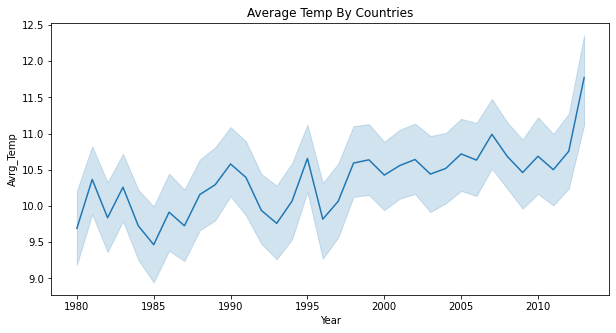

In [61]:
plt.figure(figsize = (10,5))
plt.title('Average Temp By Countries')
sns.lineplot(x = "Year", y = "Avrg_Temp", data = latest_df)
plt.show()

### Resample The Time Series to Create a More Distinct Line

In [59]:
resample_df = latest_df[['Avrg_Temp']].resample('A').mean()
resample_df.head(7)

,Avrg_Temp
Date,
1980-12-31,9.689856
1981-12-31,10.366578
1982-12-31,9.837958
1983-12-31,10.259516
1984-12-31,9.724950
1985-12-31,9.465436
1986-12-31,9.914519


### Plot the Average Temp of all the Countries, after Resampling

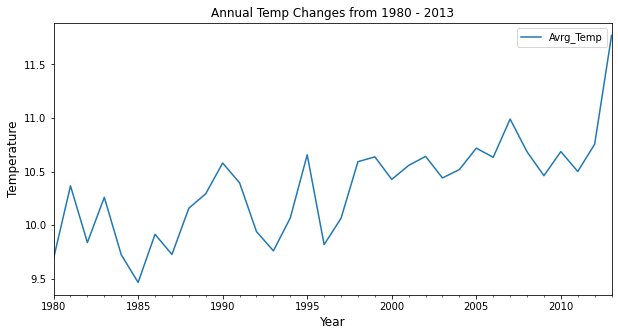

In [62]:
resample_df.plot(title = 'Annual Temp Changes from 1980 - 2013', figsize = (10,5))
plt.xlabel('Year', fontsize = 12)
plt.ylabel('Temperature', fontsize = 12)
plt.legend()

### Apply [Dickey Fuller Test](linkHere) To Determine Stationarity of Our Data
- This will tell uss whether or not to Accept or Reject the Null Hypothesis

In [73]:
print('Dickey Fuller Test Result:')
test_df = adfuller(resample_df.iloc[:,0].values, autolag = 'AIC')
df_output = pd.Series(test_df[0:4], index = ['Test Statistic', 'p-value', 'Lags Used', 'Number of Observations Used'])
for key, value in test_df[4].items():
    df_output['Critical Values (%s)'%key] = value
print(df_output)

Dickey Fuller Test Result:
Test Statistic                 -0.728209
p-value                         0.839307
Lags Used                       2.000000
Number of Observations Used    31.000000
Critical Values (1%)           -3.661429
Critical Values (5%)           -2.960525
Critical Values (10%)          -2.619319
dtype: float64


- Since the Test Statistic is greater than the Critical Values, we fail to reject the null hypothesis, therefore we say our time series data is Non Stationary

### We now [Decompose The Data](link)
- From which we will extract components and plot the Data.I.e The original Time Series, the trend, seasonal Components and Residual Components
- 

In [74]:
decomp = seasonal_decompose(resample_df, freq = 3)
trend = decomp.trend
seasonal = decomp.seasonal
residual = decomp.resid

### Now Plot the Resultant Decomposed Data Below

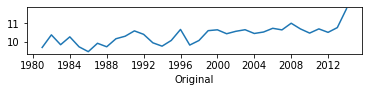

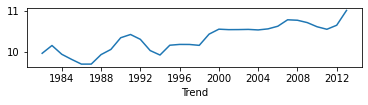

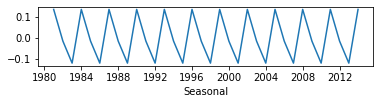

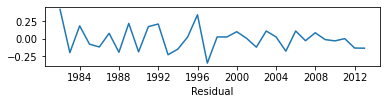

<Figure size 432x360 with 0 Axes>

In [94]:
plt.subplot(411)
plt.plot(resample_df)
plt.xlabel('Original')
plt.figure(figsize = (6,5))

plt.subplot(412)
plt.plot(trend)
plt.xlabel('Trend')
plt.figure(figsize = (6,5))

plt.subplot(413)
plt.plot(seasonal)
plt.xlabel('Seasonal')
plt.figure(figsize = (6,5))

plt.subplot(414)
plt.plot(residual)
plt.xlabel('Residual')
plt.figure(figsize = (6,5))

plt.tight_layout()

### Transform Our Data
- We will use both Moving(rolling) Average and Exponential Weighted Average

#### 1. Calculate the Rolling Mean

In [98]:
rol_mean = resample_df.rolling(window = 3, center = True).mean()

#### 2.Obtain the Exponentially Weighted Mean

In [96]:
expWghtedMean = resample_df.ewm(span = 3).mean()

#### 3.Calculate the Rolling Standard Deviation

In [ ]:
rol_stdDv = resample_df.rolling